In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import psColor, bwLabel
import os

TRAIN_DIR = os.listdir(path='../data/treino')
DATA = [cv2.imread('../data/treino/' + image_path) for image_path in TRAIN_DIR]

print("number of images in training set:", len(DATA))
print("image shape:", DATA[0].shape)

number of images in training set: 14
image shape: (530, 706, 3)


In [2]:
def showImages(imageArray, titles):
    for i, img in enumerate(imageArray):
        cv2.imshow(titles[i], img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# esta função vai dar print dos valores BGR ao contrario porque o MatPlotLib é normal e usa RGB, 
# cuidado para ele não trocar os valores e a imagem ficar estranha
def pltImages(imageArray, titles, cmap = None):
    n_images = len(imageArray)
    for i, image in enumerate(imageArray):
        plt.subplot(n_images, 1, i + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(titles[i])
        

In [3]:
#1. Leitura de imagens

image= DATA[7]
print(type(image))
print(image.dtype)
print(image.shape)
showImages([image], ["Imagem Original"])

<class 'numpy.ndarray'>
uint8
(525, 706, 3)


In [4]:
# #2. Binarização 

# def binarizacao (image, tolerance):
#     """
#     Função para realizar a binarização da imagem de modo a destacar os objetos presentes na mesma.

#     Args:
#         -image (np.array): Array da imagem em RGB que representa a imagem a ser binarização.
#         -tolerance (int): Tolerância usada para calcular o range da componente Hue da cor de fundo da imagem. 

#     Returns:
#         -image_objects (np.array): Array da imagem RGB sem fundo.
#         -bin_image (np.array): Array da imagem binarizada.
    
#     """
    
#     image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
#     #Obter a range de cores do fundo
#     hist= cv2.calcHist(image_hsv, [0], None, [179], [0,179])
#     plt.plot(hist)
#     max_hue_idx= np.argmax(hist) #Obter o valor de hue que aparece mais na imagem
#     low_hue= np.array([max_hue_idx - tolerance, 40, 0])
#     high_hue= np.array([max_hue_idx + tolerance, 255, 255])
    
#     #Tirar background da imagem através dos ranges de hue dados
#     background_mask= cv2.inRange(image_hsv, low_hue, high_hue)
#     inverted_mask= 255 - background_mask
#     image_objects= cv2.bitwise_and(image, image, mask=inverted_mask)
    
#     image_gs= cv2.cvtColor(image_objects, cv2.COLOR_BGR2GRAY)
#     thresh, bin_image = cv2.threshold(image_gs, 0, 255, cv2.THRESH_OTSU)
#     return image_objects, bin_image

# image_objects, bin_image= binarizacao(image, 20)
# showImages([image_objects, bin_image], ["Imagem sem background", "Imagem Binarizada"])


In [5]:
#2. Binarização 

def binarizacao (image, tolerance):
    """
    Função para realizar a binarização da imagem de modo a destacar os objetos presentes na mesma.

    Args:
        -image (np.array): Array da imagem em RGB que representa a imagem a ser binarização.
        -tolerance (int): Tolerância usada para calcular o range da componente de azul da cor de fundo da imagem. 

    Returns:
        -image_objects (np.array): Array da imagem RGB sem fundo.
        -bin_image (np.array): Array da imagem binarizada.
    
    """
    
    #Obter a range de cores do fundo
    hist_blue= cv2.calcHist([image], [0], None, [256], [0,256])
    # plt.figure()
    # plt.plot(hist_blue)
    max_blue_value_idx= np.argmax(hist_blue) #Obter o valor de azul que aparece mais na imagem
    low_blue= max_blue_value_idx - tolerance
    high_blue= max_blue_value_idx + tolerance

    hist_green= cv2.calcHist([image], [1], None, [256], [0,256])
    # plt.figure()
    # plt.plot(hist_green)
    max_green_value_idx= np.argmax(hist_green) #Obter o valor de verde que aparece mais na imagem
    low_green= max_green_value_idx - tolerance
    high_green= max_blue_value_idx + tolerance

    hist_red= cv2.calcHist([image], [2], None, [256], [0,256])
    # plt.figure()
    # plt.plot(hist_red)
    max_red_value_idx= np.argmax(hist_red) #Obter o valor de vvermelho que aparece mais na imagem
    low_red= max_red_value_idx - tolerance
    high_red= max_red_value_idx + tolerance

    low_color= np.array([low_blue, low_green, low_red])
    high_color= np.array([high_blue, high_green, high_red])
    
    #Tirar background da imagem através dos ranges de cores dados
    background_mask= cv2.inRange(image, low_color, high_color)
    inverted_mask= 255 - background_mask
    image_objects= cv2.bitwise_and(image, image, mask=inverted_mask)
    
    image_gs= cv2.cvtColor(image_objects, cv2.COLOR_BGR2GRAY)
    thresh, bin_image = cv2.threshold(image_gs, 0, 255, cv2.THRESH_OTSU)
    return image_objects, bin_image

image_objects, bin_image= binarizacao(image, 110)
showImages([image_objects, bin_image], ["Imagem sem background", "Imagem Binarizada"])

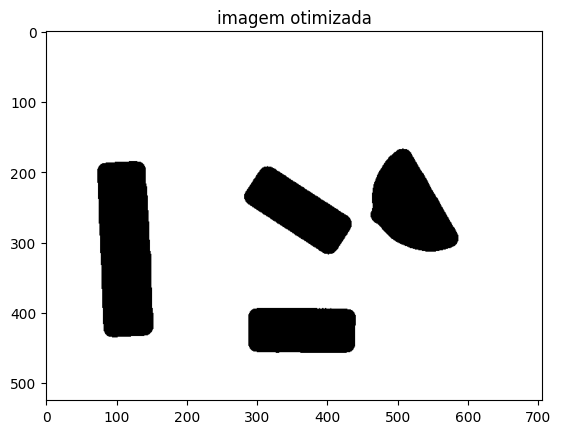

In [6]:
#3. melhoramento da imagem
def optimize_image(image):
    image_opt = image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    image_opt = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))
    image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_ERODE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
    # image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_CLOSE, kernel)
    image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_DILATE, kernel)
    return image_opt

image_opt = optimize_image(bin_image)
showImages([image_opt], ["Imagem apos melhoramento"])
pltImages([image_opt], ["imagem otimizada"], 'Greys')

In [24]:
# Construir targets
# Propriedades:
# area
# perimetro
# circ
# area_minarearect - area_real
# proporção

container_2x2 = []
container_2x4 = []
container_2x6 = []
container_2x8 = []
container_undef = []

TARGET_2x2 = []
TARGET_2x4 = []
TARGET_2x6 = []
TARGET_2x8 = []

In [ ]:
def insert_in_container(img, container, contour_idx):
    contours = get_contours(img)
    
    for i in contour_idx:
        container.append(contours[i])
        
    return container
        
def get_contours(img):

    _, bin_img = binarizacao(img, 110)
    opt_img = optimize_image(bin_img)

    contours, _ = cv2.findContours(opt_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def identify(img):
    bin_img = binarizacao(img, 110)[1]
    opt_img = optimize_image(bin_img)
    
    cnt_img = np.zeros((530, 706, 3))
    cnt_img[opt_img == 255] = [255, 255, 255]
    
    contours = get_contours(img)
    
    for i, contour in enumerate(contours):
        cv2.drawContours(cnt_img, [contour], 0, (0, 0, 255), thickness=5)
        showImages([cnt_img], [f"contour {i}"])
    
    return contours

In [ ]:
identify(DATA[0])
# Image 1
# 2x2: 0 7 8
# 2x4:
# 2x6:
# 2x8: 6
# undif: 1 3

insert_in_container(DATA[0], container_2x2, [0, 7, 8])
insert_in_container(DATA[0], container_2x8, [6])
insert_in_container(DATA[0], container_undef, [1, 3])

identify(DATA[1])
# Image 2
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[2])
# Image 3
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[3])
# Image 4
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[4])
# Image 5
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[5])
# Image 6
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[6])
# Image 7
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[7])
# Image 8
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[8])
# Image 9
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[9])
# Image 10
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[10])
# Image 11
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[11])
# Image 12
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[12])
# Image 13
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

identify(DATA[13])
# Image 14
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif:

[array([[[633, 366]],
 
        [[632, 367]],
 
        [[628, 367]],
 
        [[627, 368]],
 
        [[625, 368]],
 
        [[624, 369]],
 
        [[621, 369]],
 
        [[620, 370]],
 
        [[616, 370]],
 
        [[615, 371]],
 
        [[612, 371]],
 
        [[611, 372]],
 
        [[608, 372]],
 
        [[607, 373]],
 
        [[604, 373]],
 
        [[603, 374]],
 
        [[599, 374]],
 
        [[598, 375]],
 
        [[594, 375]],
 
        [[593, 376]],
 
        [[591, 376]],
 
        [[590, 377]],
 
        [[587, 377]],
 
        [[586, 378]],
 
        [[583, 378]],
 
        [[582, 379]],
 
        [[579, 379]],
 
        [[578, 380]],
 
        [[574, 380]],
 
        [[573, 381]],
 
        [[571, 381]],
 
        [[570, 382]],
 
        [[567, 382]],
 
        [[566, 383]],
 
        [[563, 383]],
 
        [[562, 384]],
 
        [[556, 384]],
 
        [[555, 385]],
 
        [[551, 385]],
 
        [[550, 386]],
 
        [[549, 386]],
 
        [[548, 3

In [10]:
print(" AREA      PERIM     CIRC      WIDTH     HEIGHT    DELTA     PROPOR")
for cnt in container_2x2:
    props = np.ndarray([])
    area = cv2.contourArea(cnt)
    per = cv2.arcLength(cnt, True)
    circ = 4* np.pi * area / per **2
    min_rect_area = cv2.minAreaRect(cnt)
    width = min_rect_area[1][0]
    height = min_rect_area[1][1]
    delta = (width*height) - area
    propor = width / height
    props = [area, per, circ, delta, width, height, propor]
    print(np.round(props, 1))
    

 AREA      PERIM     CIRC      WIDTH     HEIGHT    DELTA     PROPOR
[4.177e+03 2.583e+02 8.000e-01 2.845e+02 6.670e+01 6.690e+01 1.000e+00]
[4.279e+03 2.616e+02 8.000e-01 3.216e+02 6.860e+01 6.700e+01 1.000e+00]
[4.266e+03 2.577e+02 8.000e-01 2.945e+02 6.820e+01 6.680e+01 1.000e+00]


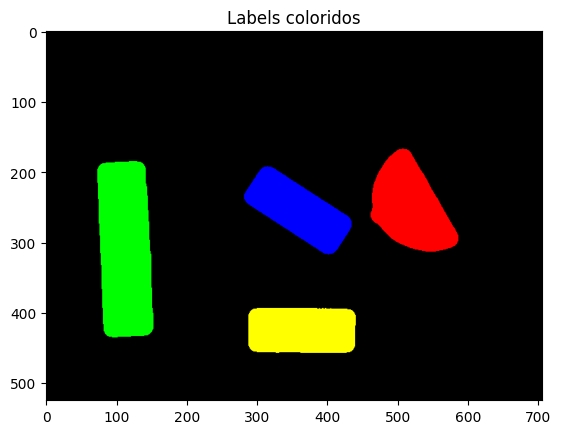

In [11]:
# Extração de componentes conexos

cc = cv2.connectedComponents(image_opt)

label_map = cc[1]

colored_image = np.zeros((image_opt.shape[0], image_opt.shape[1], 3), dtype=np.uint8)
colored_image[label_map == 1] = [255, 0, 0]
colored_image[label_map == 2] = [0, 255, 0]
colored_image[label_map == 3] = [0, 0, 255]
colored_image[label_map == 4] = [255, 255, 0]


showImages([colored_image], "contours")
pltImages([colored_image], ["Labels coloridos"])

In [12]:
#Extração de de propriedades

# Mati já te devo ter dito mas ya não consigo continuar se não tiver esta parte tua feita,
# usa a variavel cc lá de cima, a colored image é só para efeitos de display

# Na aula de hoje o prof tava a falar de reconhecimento de imagem com a cena dos centroides e tal, 
# e isso fez me pensar que ya, estas imagens são de treino porque nós vamos ter de literalmente treinar um modelo i think.
# That means we gonna have to think of how we can do that.
# Acho que variaveis de entrada seriam pelo menos a area e o perimetro, mas devem haver mais que conseguimos implementar.
# Vamos continuar a fazer isto tudo normalmente, mas deixa tudo o que é possiveis variaveis que identificam as peças (centroides de 
# area, perimetro, etc... para cada tipo diferente de peça) como inputs da tua função, o nosso modelo depois há de adaptar esses valores 
# com o treino que lhe dermos




In [13]:
#Extração de de propriedades

def extracao_propriedades (imagem_otimizada):
    num_labels, label_map_stats, stats, centroides= cv2.connectedComponentsWithStats(imagem_otimizada) 
    contours, hierarchy = cv2.findContours(imagem_otimizada, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    
    propriedades= np.zeros((num_labels - 1, 10))
    
    for i in range(1,num_labels): #Skip no índice 0 porque corresponde ao background
        x= stats[i, cv2.CC_STAT_LEFT]
        y= stats[i, cv2.CC_STAT_TOP]
        width= stats[i, cv2.CC_STAT_WIDTH]
        height= stats[i, cv2.CC_STAT_HEIGHT]
        area= stats[i, cv2.CC_STAT_AREA]
        #A indexação está a ser feita desta forma porque o array de contornos tem a ordem inversa do array de connected components
        perimetro = cv2.arcLength(contours[len(contours) - i], True)  
        circularidade= 4* np.pi * area / perimetro **2
        rect = cv2.minAreaRect(contours[len(contours) - i])
        
        vetor_propriedades= np.array([x, y, width, height, area, centroides[i][0], centroides[i][1], circularidade, rect[1][0], rect[1][1]])
        propriedades[i-1]= vetor_propriedades
        
    return propriedades

propriedades_objectos= extracao_propriedades(image_opt)

print(f"{propriedades_objectos[:,2]}")

[125.  80. 153. 153.]


In [14]:
contours, hierarchy = cv2.findContours(image_opt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt_image = np.zeros((525, 706, 3))
cnt_image[image_opt == 255] = [255, 255, 255]

cnt = contours[0]

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int64(box)
cnt_image = cv2.drawContours(cnt_image, [box], 0, (0,0,255), 2)
area = cv2.contourArea(box)
print(area)
area_real = cv2.contourArea(cnt)
print(area - area_real)

cnt = contours[1]

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int64(box)
cnt_image = cv2.drawContours(cnt_image, [box], 0, (0,0,255), 2)
area = cv2.contourArea(box)
print(area)
area_real = cv2.contourArea(cnt)
print(area - area_real)


showImages([cnt_image], ["test"])

9576.0
289.5
9824.0
491.0


In [15]:
#Classificação de objetos

def classificacao_objetos (propriedades, tolerancia_area= 10000):
    respostas= np.zeros((len(propriedades), 2))
    
    for i, vetor_prop in enumerate(propriedades):
        minRectArea= vetor_prop[8] * vetor_prop[9]
        area= vetor_prop[4]
        if minRectArea - area < tolerancia_area:
            width= vetor_prop[2]
            height= vetor_prop[3]
            if np.abs(height - width) < 10:
                respostas[i]= np.array([2,2])
            else:
                cube_area= vetor_prop[8]**2
                if np.abs(cube_area * 2 - minRectArea) < tolerancia_area:
                    respostas[i]= np.array([4,2])
                elif np.abs(cube_area * 3 - minRectArea) < tolerancia_area:
                    respostas[i]= np.array([6,2])
                elif np.abs(cube_area * 4 - minRectArea) < tolerancia_area:
                    respostas[i]= np.array([8,2])
    return respostas

resultados= classificacao_objetos (propriedades_objectos)
print(resultados)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [4. 2.]]


In [16]:
#Teste

imagem_teste= DATA[7]
showImages([imagem_teste], ["Imagem Original"])

imagem_teste_objects, bin_imagem_teste= binarizacao(imagem_teste, 10)
showImages([imagem_teste_objects, bin_imagem_teste], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste_opt = optimize_image(bin_imagem_teste)
showImages([imagem_teste_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste= extracao_propriedades(imagem_teste_opt)
resultados_teste= classificacao_objetos (propriedades_objectos_teste)
print(resultados_teste)

[[0. 0.]
 [4. 2.]]


In [17]:
#Teste

imagem_teste2= DATA[4]
showImages([imagem_teste2], ["Imagem Original"])

imagem_teste2_objects, bin_imagem_teste2= binarizacao(imagem_teste2, 30)
showImages([imagem_teste2_objects, bin_imagem_teste2], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste2_opt = optimize_image(bin_imagem_teste2)
showImages([imagem_teste2_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste2= extracao_propriedades(imagem_teste2_opt)
resultados_teste2= classificacao_objetos (propriedades_objectos_teste2)
print(resultados_teste2)

[[0. 0.]]
